## Filtros

In [6]:
import numpy as np
import cv2 as cv
import supervision as sv
from skimage.util import random_noise

#### Filtro Gaussiano

In [7]:
# Parámetros:
# ksize - Tamaño del núcleo, positivo impar (3,5,...)
# sigma - Desvío estándar de la Gaussiana. Si no es positivo, se calcula como sigma = 0.3*((ksize-1)*0.5 - 1) + 0.8 
# ktype - Tipo de coeficientes del filtro (Optional). Puede ser CV_32F o CV_64F
kernel_1d = cv.getGaussianKernel(ksize=5, sigma=1.5) 
kernel_2d = kernel_1d * kernel_1d.T
print('Kernal 1d:')
print(f'{kernel_1d.T}')

print('Kernel 2d:')
print(kernel_2d)
print(f'ganancia: {np.sum(kernel_2d)}')

Kernal 1d:
[[0.12007838 0.23388076 0.29208172 0.23388076 0.12007838]]
Kernel 2d:
[[0.01441882 0.02808402 0.0350727  0.02808402 0.01441882]
 [0.02808402 0.05470021 0.06831229 0.05470021 0.02808402]
 [0.0350727  0.06831229 0.08531173 0.06831229 0.0350727 ]
 [0.02808402 0.05470021 0.06831229 0.05470021 0.02808402]
 [0.01441882 0.02808402 0.0350727  0.02808402 0.01441882]]
ganancia: 0.9999999999999999


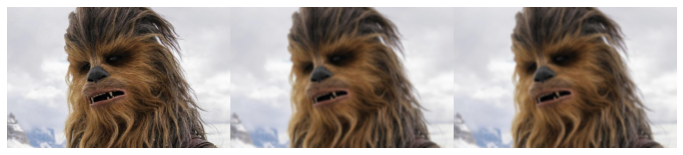

In [8]:
# Suavizado Gaussiano usando el Kernel
#=====================================
img_orig = cv.imread('chewbacca.jpg')
 
# Creamos un núcleo Gaussiano unidimensional
kX = cv.getGaussianKernel(ksize=17, sigma=5)
kY = cv.getGaussianKernel(ksize=17, sigma=5)
 
# Aplicamos el filtro Gaussiano. Con distinto núcleo para X e Y!
result_a = cv.sepFilter2D(img_orig,  ddepth=-1, kernelX=kX, kernelY=kY)

# Más fácil utilizando una única línea
# (cuando el kernel es cuadrado)
result_b = cv.GaussianBlur(img_orig, ksize=(17, 17), sigmaX=5,  sigmaY=5)

# Mostramos la imagen
out1 = cv.hconcat([img_orig, result_b, result_a])

sv.plot_image(out1)

#### Filtro de media y mediana



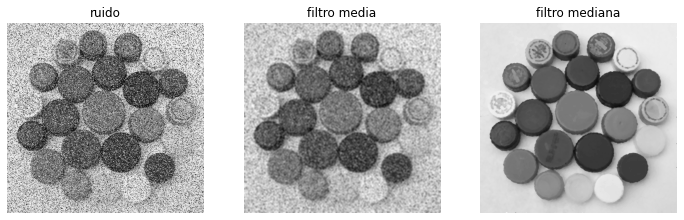

In [9]:
img2 = cv.imread('tapitas.jpg',0)

# Agregar ruido salt&pepper a la imagen
noise_img = random_noise(img2, mode="s&p", amount=0.3)
noise_img = np.array(255*noise_img, dtype = 'uint8')

# Otra manera de agregar ruido (no es salt&pepper) con numpy
# gauss = np.random.normal(0,1,img2.size)
# gauss = gauss.reshape(img2.shape[0],img2.shape[1]).astype('uint8')
# noise_img = img2 + img2 * gauss

# Aplicar el filtro de media
mean = cv.blur(noise_img, (5,5))

# Aplicar el filtro de mediana
median = cv.medianBlur(noise_img, 5)
 
# Mostrar la imagen
sv.plot_images_grid(
    images=[noise_img, mean, median], 
    titles=["ruido", "filtro media", "filtro mediana"],
    grid_size=(1, 3))

#### DoG

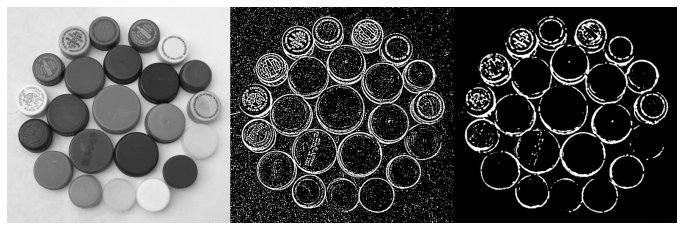

In [10]:
# Cargamos la imagen
img_orig = cv.imread('tapitas.jpg',0)
#img_orig = cv.imread('chewbacca.jpg',0)

# Aplicamos un suavizado Gaussiano de 5x5
low_sigma = cv.GaussianBlur(img_orig, (5,5), sigmaX=1)
high_sigma = cv.GaussianBlur(img_orig, (5,5),sigmaX=1.5)

# Calculamos el DoG por sustracción
dog = low_sigma - high_sigma

# Aplico filtro de mediana para mejorar el resultado
median = cv.medianBlur(dog, 5)

# Mostramos la imagen
out1 = cv.hconcat([img_orig, dog, median])
sv.plot_image(out1)

#### Unsharp masking

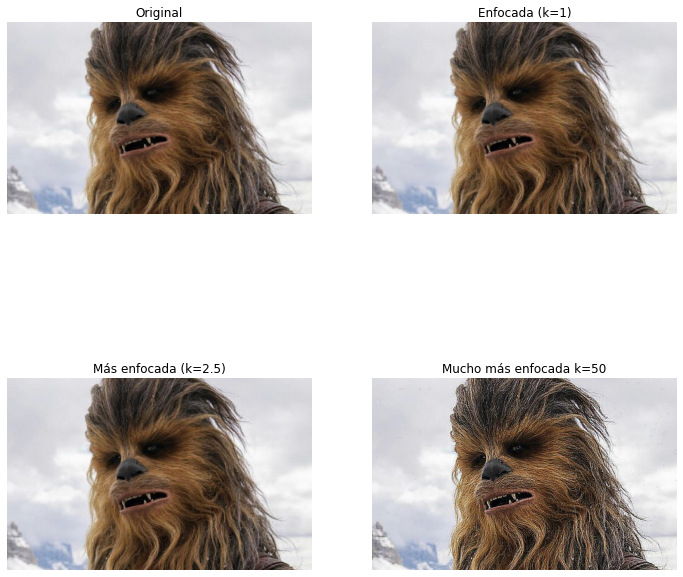

In [14]:
# Cargar la imagen (la carga como BGR)
img_orig = cv.imread("chewbacca.jpg")

# Suavizar la imagen
gauss = cv.GaussianBlur(img_orig, (7,7), 0.5)
# Aplicar la máscara de enfoque: 
# addWeighted calcula la suma pesada de dos arreglos según: dst(I)=saturate(src1(I)∗alpha+src2(I)∗beta+gamma)
# parámetros: (src1(I),alpha,src2(I),beta,gamma)
img_sharp = cv.addWeighted(img_orig, 2, gauss, -1, 0) #k=1

# Más enfocada
k=2.5
img_sharp2 = cv.addWeighted(img_orig, k+1, gauss, -k, 0)

# Mucho más enfocada
k=50
img_sharp3 = cv.addWeighted(img_orig, k+1, gauss, -k, 0)


sv.plot_images_grid(
    images=[img_orig, img_sharp, img_sharp2, img_sharp3],
    titles=['Original', 'Enfocada (k=1)', 'Más enfocada (k=2.5)', f'Mucho más enfocada k={k}'],
    grid_size=(2, 2)
)

# Nueva figura
#    fig = plt.figure()
# /
#    ax1=plt.subplot(221)
#    ax1.set_title('Original')
#    ax1.imshow(img_orig)
#    ax2=plt.subplot(222)
#    ax2.set_title('Enfocada (k=1)')
#    ax2.imshow(img_sharp)
#    ax3=plt.subplot(223)
#    ax3.set_title('Más enfocada (k=2.5)')
#    ax3.imshow(img_sharp2)
#    ax4=plt.subplot(224)
#    ax4.set_title(f'Mucho más enfocada {k}')
#    ax4.imshow(img_sharp3)
#    fig.show()